# Similarity Matching

In [1]:
%run setup.py

In [2]:
def map_age_group(age_range):
    if age_range >=  20:
        return '>20'
    elif age_range >= 15:
        return '15-20'
    elif age_range >= 10:
        return '10-15'
    elif age_range >= 5:
        return '5-10'
    else:
        return '0-5'
    
years = list(range(2003, 2023))
age_groups = ['0-5', '5-10', '10-15', '15-20', '>20']

year_df = pd.DataFrame(columns=['Year', 'Age Group'])

for year in years:
    for age_group in age_groups:
        year_df = year_df.append({'Year': year, 'Age Group': age_group}, ignore_index=True)

In [3]:
# Load data
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"
# Append data to one dataframe
df = df_Invited.append(df_Proceedings).reset_index(drop=True)
df = df[df['Productivity'] != 0]
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['index'] = df.index
df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity,Source,log(Paper Count),index
1,Tadahiro Ohm,2003,ASPDAC,Tadahiro,NaN,Ohm,M,27,92,1993,10,Asia and South Pacific Design Automation Confe...,Computer Architecture,2.700000,Invited,3.295837,1
3,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4,1962,42,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.095238,Invited,1.386294,3
4,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196,1987,17,Asia and South Pacific Design Automation Confe...,Computer Architecture,6.588235,Invited,4.718499,4


## Nearest Neighbor (Male -> Female) with one neighbor

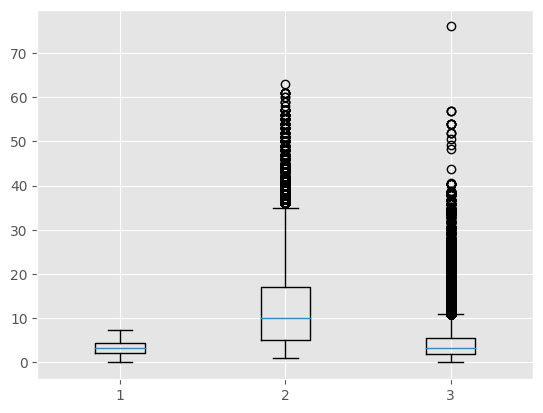

In [4]:
plt.boxplot([df['log(Paper Count)'],df['Age'],df['Productivity']])
plt.show()

In [4]:
# df = df.groupby('Main Topic').get_group('M')

df_F = df[df['gender'] == "F"]
df_M = df[df['gender'] == "M"]

nbrs = NearestNeighbors(n_neighbors=1).fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# # Print the nearest neighbor results
for i in range(len(indices[0:10])):
    print(f"Male {df_M.iloc[i]['Full name']} is most similar to female {df_F.iloc[indices[i][0]]['Full name']} with a distance of {distances[i]}")

Male Tadahiro Ohm is most similar to female Evdokia Nikolova with a distance of [0.]
Male Gary L. Baldwi is most similar to female Andee Rubin with a distance of [1.34745412]
Male Rudy Lauwereins is most similar to female Joelle Pineau with a distance of [0.]
Male Rajeev Madhavan is most similar to female Rosario Uceda-Sosa with a distance of [0.]
Male Jan M. Rabaey is most similar to female Lu Chen with a distance of [0.]
Male Alberto Sangiovanni-Vincentelli is most similar to female Micha Sharir with a distance of [0.03038176]
Male Satoru Ito is most similar to female Meg Young with a distance of [0.]
Male Yukichi Niwa is most similar to female Yoojung Kim with a distance of [0.]
Male Rob Rutenbar is most similar to female Cindy E. Hmelo-Silver with a distance of [0.]
Male Takayasu Sakurai is most similar to female Eva Tardos with a distance of [0.]


In [5]:
# Create a new dataframe to store the results
results = pd.DataFrame(columns=['Male Name', 'Male Type', 'Male Age', 'Male Year', 'Female Name', 'Female Type', 'Female Age', 'Female Year'])

# Iterate over each male data point and its nearest neighbor
for i in tqdm(range(len(indices))):
    male_name = df_M.iloc[i]['Full name']
    male_type = df_M.iloc[i]['Source']
    male_year = df_M.iloc[i]['Year']
    male_age = df_M.iloc[i]['Age']
    female_index = indices[i][0] # Index of the female in the original dataframe
    female_name = df_F.iloc[female_index]['Full name']
    female_type = df_F.iloc[female_index]['Source']
    female_age = df_F.iloc[female_index]['Age']
    female_year = df_F.iloc[female_index]['Year']
    results.loc[i] = [male_name, male_type,male_age, male_year, female_name, female_type,female_age,female_year]

# Print the results dataframe
results.head()

100%|██████████| 155948/155948 [18:59<00:00, 136.85it/s]


,Male Name,Male Type,Male Age,Male Year,Female Name,Female Type,Female Age,Female Year
0,Tadahiro Ohm,Invited,10,2003,Evdokia Nikolova,Proceedings,10,2015
1,Gary L. Baldwi,Invited,42,2004,Andee Rubin,Proceedings,42,2020
2,Rudy Lauwereins,Invited,17,2004,Joelle Pineau,Proceedings,17,2017
3,Rajeev Madhavan,Invited,11,2005,Rosario Uceda-Sosa,Proceedings,11,2004
4,Jan M. Rabaey,Invited,20,2005,Lu Chen,Proceedings,20,2020


In [6]:
results_heatmap = results.copy()

### Ratio Plot with same year and age group
I start be filtering to only include the rows where the male and the female year is the same.

In [7]:
results['Year Check'] = results['Female Year'] == results['Male Year']
results['Male Age Group'] = results['Male Age'].apply(map_age_group)
results['Female Age Group'] = results['Female Age'].apply(map_age_group)
results['Age Group Check'] = results['Female Age'] == results['Male Age']
similar_df = results[results['Year Check'] == True]

In [8]:
df_P_males = similar_df.groupby('Male Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name = "Male Ratio")
df_P_females = similar_df.groupby('Female Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name = "Female Ratio")

# Define empty dataframe with years
df_year = pd.DataFrame(columns=['Year'], data=years)
df_year

df_ratio = df_year.merge(df_P_males, left_on="Year",right_on="Male Year",how="left")
df_ratio = df_ratio.merge(df_P_females, left_on="Year",right_on="Female Year",how='left')
df_ratio['ratio'] = np.divide(df_ratio['Female Ratio'],df_ratio['Male Ratio'])

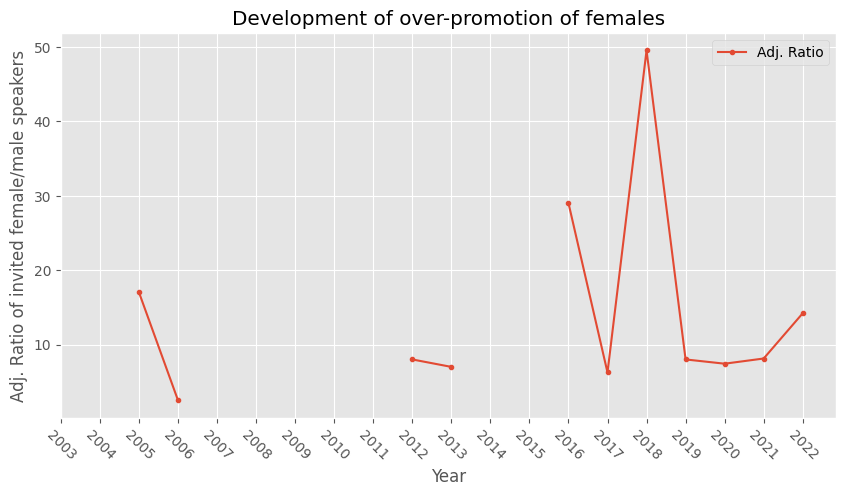

In [9]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), df_ratio['ratio'], '.-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.title('Development of over-promotion of females')
plt.show()

### Ratio Plot with different year
Here I only show when the female and the male year is the same.

In [10]:
P_males = list(results.groupby('Male Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'])
P_females = list(results.groupby('Female Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'])
ratio = np.divide(P_females,P_males)

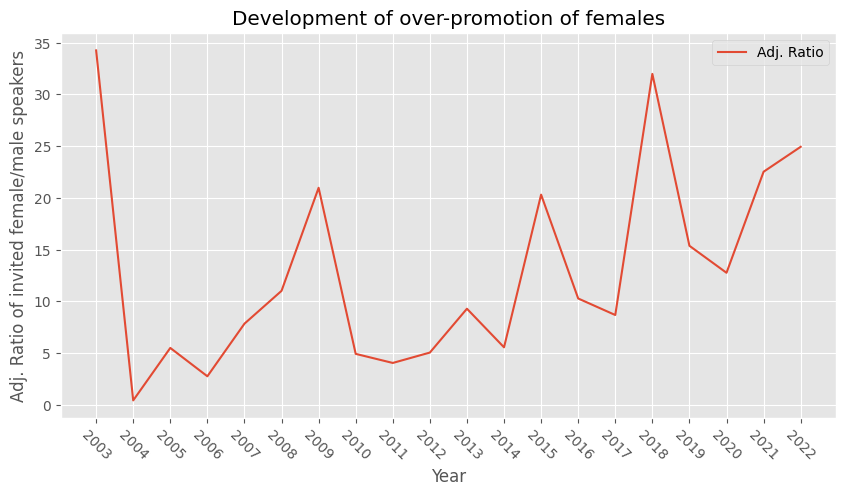

In [11]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), ratio, '-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.title('Development of over-promotion of females')
plt.show()

### Ratio plot with male year
Here I plot when the year is only the males year.

In [12]:
P_males = list(results.groupby('Male Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'])
P_females = list(results.groupby('Male Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'])
ratio = np.divide(P_females,P_males)

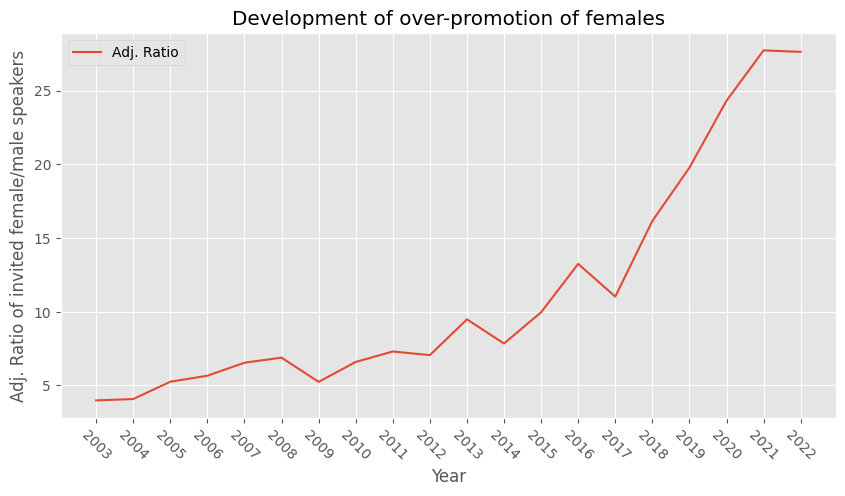

In [13]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), ratio, '-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.title('Development of over-promotion of females')
plt.show()

### Heatmap

In [7]:
results_heatmap['Male Age Group'] = results_heatmap['Male Age'].apply(map_age_group)
results_heatmap['Female Age Group'] = results_heatmap['Female Age'].apply(map_age_group)

In [8]:
Ratio_M = results_heatmap.groupby(['Male Year', 'Male Age Group'])['Male Type'].value_counts(normalize=True).loc[:,:, 'Invited'].reset_index( name='Male Ratio')
Ratio_F = results_heatmap.groupby(['Male Year', 'Female Age Group'])['Female Type'].value_counts(normalize=True).loc[:,:, 'Invited'].reset_index( name='Female Ratio')

In [9]:
years = list(range(2003, 2023))
age_groups = ['0-5', '5-10', '10-15', '15-20', '>20']

df_new = pd.DataFrame(columns=['Year', 'Age Group'])

for year in years:
    for age_group in age_groups:
        df_new = df_new.append({'Year': year, 'Age Group': age_group}, ignore_index=True)

In [10]:
df_new = df_new.merge(Ratio_M, how='left', left_on=['Year', 'Age Group'], right_on=['Male Year' ,'Male Age Group'])
df_new = df_new.merge(Ratio_F, how='left', left_on=['Year', 'Age Group'], right_on=['Male Year' ,'Female Age Group']) #TODO
df_new['Proportion'] = np.divide(df_new['Female Ratio'],df_new['Male Ratio'])

In [11]:
df_pivot = df_new.pivot_table(values='Proportion', index='Year', columns='Age Group')
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

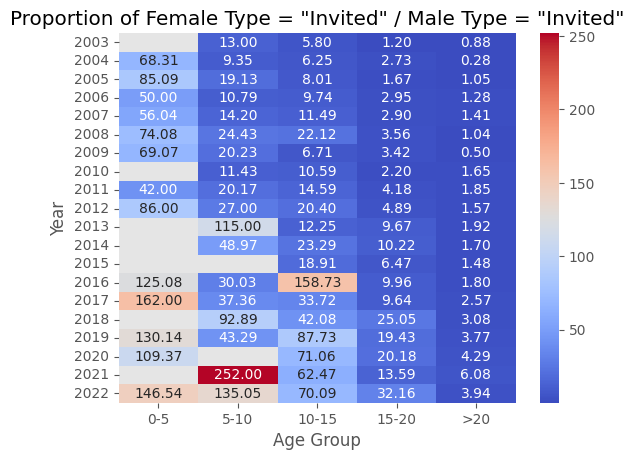

In [12]:
df_pivot = df_new.pivot_table(values='Proportion', index='Year', columns='Age Group')
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Proportion of Female Type = "Invited" / Male Type = "Invited"')
plt.show()

## Nearest Neighbor (Male -> Female) with 5 neighbors
Now I try with 5 neighbors instead of 1. But I still use Male Year on the females. And their year might not be the same.

In [17]:
# df = df.groupby('Main Topic').get_group('M')
k = 5
df_F = df[df['gender'] == "F"].reset_index( drop=True)
# df_F.set_index('index')
df_M = df[df['gender'] == "M"]

nbrs = NearestNeighbors(n_neighbors=k , metric="euclidean").fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# # # Print the nearest neighbor results
for i in range(len(indices[0:3])):
    print(f"Male {df_M.iloc[i]['Full name']} is most similar to female {df_F.iloc[indices[i]]['Full name']} with a distance of {distances[i]}")
#     df_M.loc[i, 'Similar Females'] = ",".join(map(str, indices[i])) # assign to the new column

Male Tadahiro Ohm is most similar to female 2101         Simone Bova
5625          Sheng Chen
2925         Seema Nagar
1624    Evdokia Nikolova
5231              Ji Liu
Name: Full name, dtype: object with a distance of [0. 0. 0. 0. 0.]
Male Gary L. Baldwi is most similar to female 22476       Andee Rubin
35870      Ilana Segall
23499     Lan N. Nguyen
13684    Janet M. Baker
5320      Lan N. Nguyen
Name: Full name, dtype: object with a distance of [1.34745412 2.00000469 2.0250811  2.44061234 2.59886948]
Male Rudy Lauwereins is most similar to female 87      Joelle Pineau
7681    Maire O'Neill
2336    Joelle Pineau
1229        Wenjie Li
1230        Wenjie Li
Name: Full name, dtype: object with a distance of [0. 0. 0. 0. 0.]


In [18]:
n = 1000
ratio_list = []

for i in tqdm(range(0,n)):
    # Step 1: Find the info of the female speakers by randomly selecting one female
    results = df_M.copy()
    results['Female Index'] = [random.choice(row) for row in indices.tolist()] # select female
    results = results.merge(right = df_F, left_on='Female Index', right_index=True, how='left',suffixes=['_M','_F']) # merge info about females
    
    # Step 2: Calculate the ratio of female invited speakers and male invited speakers per year
    P_males = results.groupby('Year_M')['Source_M'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_M')
    P_females = results.groupby('Year_M')['Source_F'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_F')
    ratio = np.divide(P_females['fraction_F'],P_males['fraction_M'])
    # Save the list of ratio and add new ratio after each loop
    ratio_list.append(ratio)            
            
# Step 3: Based on the list of fraction by year, calculate the mean and std.
arr = np.array(ratio_list)             
mean_ratio = np.mean(arr[:,:], axis=0)
std_ratio = np.std(arr, axis=0)

100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]


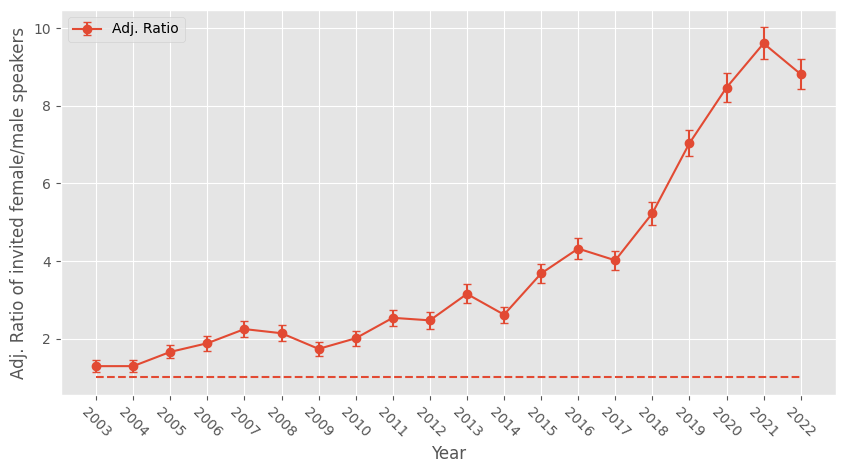

In [19]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(range(2003,2023), mean_ratio, yerr=std_ratio, fmt='o-', capsize=3,label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.hlines(1, 2003, 2022, linestyles='dashed')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

## Nearest Neighbor (Female -> Male)

100%|██████████| 39788/39788 [00:55<00:00, 716.79it/s]


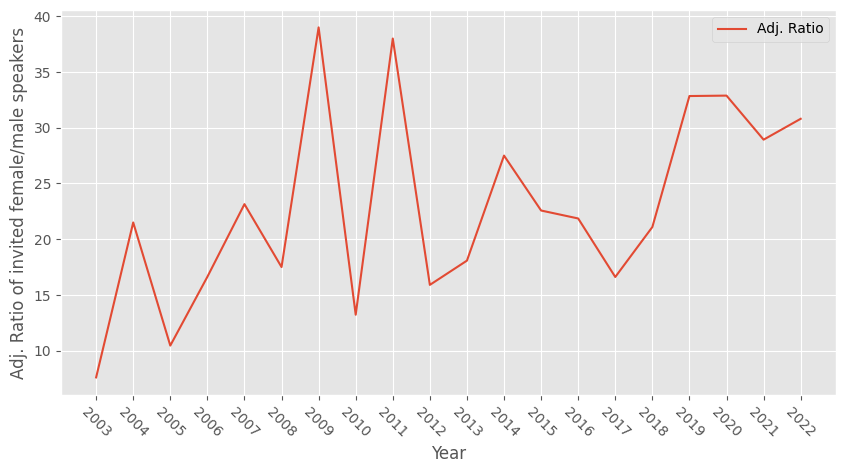

In [46]:
# df = df.groupby('Main Topic').get_group('M')

# df_F = df[df['gender'] == "M"]
# df_M = df[df['gender'] == "F"]

# nbrs = NearestNeighbors(n_neighbors=1).fit(df_F[['log(Paper Count)','Productivity','Age']])
# distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# # Create a new dataframe to store the results
# results = pd.DataFrame(columns=['Male Name', 'Male Type', 'Year', 'Female Name', 'Female Type'])

# # Iterate over each male data point and its nearest neighbor
# for i in tqdm(range(len(indices))):
#     male_name = df_M.iloc[i]['Full name']
#     male_type = df_M.iloc[i]['Source']
#     year = df_M.iloc[i]['Year']
#     female_index = indices[i][0] # Index of the female in the original dataframe
#     female_name = df_F.iloc[female_index]['Full name']
#     female_type = df_F.iloc[female_index]['Source']
#     results.loc[i] = [male_name, male_type, year, female_name, female_type]


P_males = list(results.groupby('Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'])
P_females = list(results.groupby('Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'])
ratio = np.divide(P_females,P_males)

fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), ratio, '-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

## Cosine Similarity

In [ ]:
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ", ".join(map(str, similar_females_index)) # assign to the new column

# Step 4: replace index with names in 'Similar Females' column
name_map = dict(zip(df.index, df['Full name']))
df['Similar Females'] = df['Similar Females'].apply(lambda x: [name_map[int(i)] for i in x.split(',') if i])

df.head()

In [4]:
# Step 1: create a list of tuples containing all possible combinations of males and females who are similar
links = [(node,name) for node in list(df['Full name'].values) for name in df[df['Full name'] == node]['Similar Females'].values[0]]

# Step 2: remove duplicates
links = list(dict.fromkeys(links))

# Step 3: print
links[0:10]

Check threshold for cosine similarity

In [3]:
# takes about 1 minute
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a list to store similarity values and plot histogram
similarity_list = []
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i]
    similarity_list.append(similarities)
    
combined_list = np.concatenate(similarity_list).tolist()

In [4]:
import numpy as np
from scipy.stats import percentileofscore

# Calculate the threshold that captures 95% of the data
percentile = 95
threshold_index = int(round((percentile/100) * (len(combined_list)-1)))
threshold = sorted(combined_list)[threshold_index]

print("Threshold value:", threshold)

Threshold value: 0.9526507203527652


In [ ]:
# takes a loooong time
plt.hist(arr, bins=70)
plt.xlabel('Similarity mesure between male and female speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities Between Male and Femlaes Speakers')

## Ratio plot

In [3]:
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .952 # threshold value
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
ratio_list = []
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    df_filtered = df[(df['gender'] == 'M') & (df['random_index'] != "")]
    df_filtered = df_filtered[['Full name', 'Year','Source','random_index']]
    
    A = pd.merge(df_filtered, df, left_on='random_index', right_on='index', how='left')
    A = A[['Full name_x', 'Source_x', 'Year_x', 'Full name_y', 'Source_y']]
    A = A.rename(columns={'Full name_x': "Full Name_M", 
                                        "Source_x": "source_M",
                                        "Year_x": "year_M",
                                        "Full name_y": "Full Name_F",
                                        "Source_y": "source_F"})
    
    # Step 6: Calculate the ratio of female invited speakers and male invited speakers per year
    P_males = A.groupby('year_M')['source_M'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_M')
    P_females = A.groupby('year_M')['source_F'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_F')
    ratio = np.divide(P_females['fraction_F'],P_males['fraction_M'])
    # Save the list of ratio and add new ratio after each loop
    ratio_list.append(ratio)            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.
arr = np.array(ratio_list)             
mean_ratio = np.mean(arr[:,:], axis=0)
std_ratio = np.std(arr, axis=0)

In [251]:
# df_true = df.groupby(['Year','gender'])['Source'].value_counts(normalize=True).reset_index(name='fraction')
# ratio_true = np.divide(list(df_true[(df_true['gender'] == "F") & (df_true['Source'] == "Invited")]['fraction']), list(df_true[(df_true['gender'] == "M") & (df_true['Source'] == "Invited")]['fraction']))

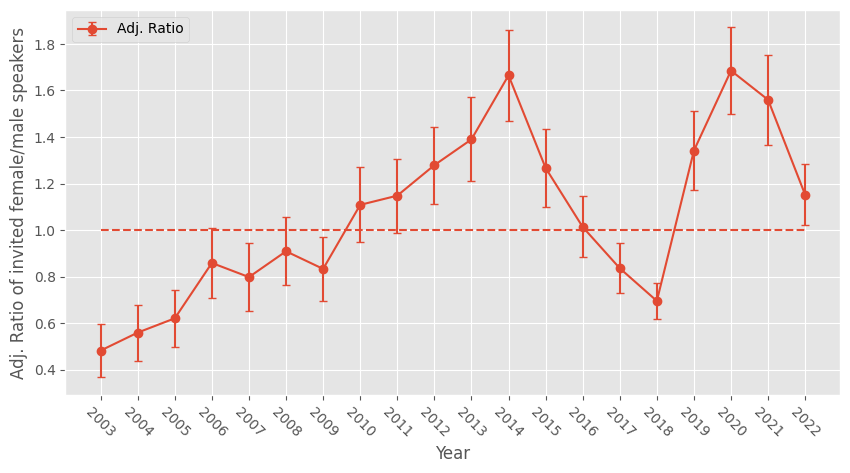

In [263]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(range(2003,2023), mean_ratio, yerr=std_ratio, fmt='o-', capsize=3,label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.hlines(1, 2003, 2022, linestyles='dashed')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

In [3]:
'''
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
fractions = {}
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    male_list = []
    female_list = []
    year_list = []
    source_F_list = []
    source_M_list = []

    # filter before the loop
    df_filtered = row['gender'] == 'M' and row['Similar Females'] != ""

    for i, row in df.iterrows():
        if row['gender'] == 'M' and row['Similar Females'] != "":    
            male_list.append(row['Full name'])
            female_list.append(df.loc[row['random_index'],'Full name'])
            year_list.append(int(row['Year']))
            source_F_list.append(df.loc[row['random_index'],'Source'])
            source_M_list.append(row['Source'])
            
    A = pd.DataFrame({
        'name_M': male_list,
        'year_M': year_list,
        'source_M': source_M_list,
        'name_F': female_list,
        'source_F': source_F_list,
    })
            
    # Step 6: Calculate the ratio of female invited speakers per year
    A_grouped = A.groupby(['year_M', 'source_F']).size().reset_index(name='count')
    A_invited = A_grouped[A_grouped['source_F'] == 'Invited']
    A_invited_grouped = A.groupby(['year_M'])['source_F'].count().reset_index(name='total')
    B = pd.merge(A_invited, A_invited_grouped, on='year_M')
    B['fraction'] = B['count'] / B['total'] # number of females invited / total number of speakers for that year
    B = B[['year_M', 'fraction']]
    
    for index, row in B.iterrows():
        year = row['year_M']
        fraction = row['fraction']
        if year in fractions:
            fractions[year].append(fraction)
        else:
            fractions[year] = [fraction]
            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.             
C = pd.DataFrame(columns=['year', 'mean', 'std'])
for year in fractions:
    mean = sum(fractions[year]) / len(fractions[year])
    std = pd.Series(fractions[year]).std()
    C = C.append({'year': year, 'mean': mean, 'std': std}, ignore_index=True)
C['year'] = C['year'].astype(int)

# Step 8: Save table for reference
C.to_csv('Fraction_of_invited_Females.csv', index=False)
'''

100%|██████████| 1000/1000 [37:28<00:00,  2.25s/it]
